In [30]:
import pandas as pd
import pickle
import numpy as np

import h5py
import pydot
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Add
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import RMSprop, Adagrad, Adam
from keras.utils import plot_model
from keras.losses import binary_crossentropy
#from keras.metrics import precision as prec_metric
import keras.backend as K

import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns",80)

In [31]:
df = pd.read_csv('../data/final_data.csv')
df = df.dropna(how='any',axis=0)
print(df)

                  timestamp ACCIDENTDATE ACCIDENTTIME  Route_No  \
0       2006-02-23 15:00:00   2006-02-23     15:00:00    180994   
1       2006-02-23 15:00:00   2006-02-23     15:00:00    213222   
2       2006-02-06 21:00:00   2006-02-06     21:00:00      5044   
3       2006-02-06 21:00:00   2006-02-06     21:00:00    138932   
4       2006-01-09 17:00:00   2006-01-09     17:00:00      5026   
5       2006-01-09 17:00:00   2006-01-09     17:00:00      5044   
6       2006-01-09 17:00:00   2006-01-09     17:00:00    150347   
7       2006-01-24 17:00:00   2006-01-24     17:00:00      2090   
8       2006-01-24 17:00:00   2006-01-24     17:00:00    159508   
9       2006-02-24 07:00:00   2006-02-24     07:00:00      2460   
10      2006-02-24 07:00:00   2006-02-24     07:00:00    105177   
11      2006-01-17 08:00:00   2006-01-17     08:00:00      5127   
12      2006-03-05 21:00:00   2006-03-05     21:00:00      5127   
13      2006-01-17 08:00:00   2006-01-17     08:00:00      587

In [32]:
one_hot_field = ['hour', 'DAY_OF_WEEK', 'month', 'Light_Condition', 'ROAD_TYPE', 'wind_dir', 'SURFACE_COND', 'NODE_TYPE', 'Deg_Urban_Name']

# One-Hot encode a couple of variables
df_one_hot = pd.get_dummies(df,columns=one_hot_field)

# Get the one-hot variable names
one_hot_feature_names = pd.get_dummies(df[one_hot_field],columns=one_hot_field).columns.tolist()
df_one_hot.head()

,timestamp,ACCIDENTDATE,ACCIDENTTIME,Route_No,segment_id,SPEED_ZONE,DIRECTION_LOCATION,snowing,raining,foggy,smoke,dust,strong_winds,wind_speed,temperature,target,accident_counts,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,...,ROAD_TYPE_VALLEY,ROAD_TYPE_VIEW,ROAD_TYPE_VISTA,ROAD_TYPE_W,ROAD_TYPE_WALK,ROAD_TYPE_WAY,ROAD_TYPE_WEST,ROAD_TYPE_WYND,wind_dir_CALM,wind_dir_E,wind_dir_ENE,wind_dir_ESE,wind_dir_N,wind_dir_NE,wind_dir_NNE,wind_dir_NNW,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SSE,wind_dir_SSW,wind_dir_SW,wind_dir_W,wind_dir_WNW,wind_dir_WSW,SURFACE_COND_1,SURFACE_COND_2,SURFACE_COND_3,SURFACE_COND_4,SURFACE_COND_5,SURFACE_COND_9,NODE_TYPE_I,NODE_TYPE_N,Deg_Urban_Name_LARGE_PROVINCIAL_CITIES,Deg_Urban_Name_MELBOURNE_CBD,Deg_Urban_Name_MELB_URBAN,Deg_Urban_Name_RURAL_VICTORIA,Deg_Urban_Name_SMALL_CITIES,Deg_Urban_Name_SMALL_TOWNS,Deg_Urban_Name_TOWNS
0,2006-02-23 15:00:00,2006-02-23,15:00:00,180994,1140706800180994,60,N,0,0,0,0,0,0,12.0,93.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,2006-02-23 15:00:00,2006-02-23,15:00:00,213222,1140706800213222,60,N,0,0,0,0,0,0,12.0,93.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,2006-02-06 21:00:00,2006-02-06,21:00:00,5044,11392596005044,60,SE,0,0,0,0,0,0,18.0,59.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,2006-02-06 21:00:00,2006-02-06,21:00:00,138932,1139259600138932,60,SE,0,0,0,0,0,0,18.0,59.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,2006-01-09 17:00:00,2006-01-09,17:00:00,5026,11368260005026,60,SW,0,0,0,0,0,0,7.0,74.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0


## Features
These are currently:

- hour
- DAY_OF_WEEK
- month
- SPEED_ZONE
- Light_Condition
- ROAD_TYPE
- DIRECTION_LOCATION
- snowing
- raining
- foggy
- smoke
- dust
- strong_winds
- wind_dir
- wind_speed
- temperature
- SURFACE_COND
- NODE_TYPE
- Deg_Urban_Name

These will be rescaled by scikit-learn's standard rescaler

In [33]:
y = df['target'].values
float_feature_names = [
    'SPEED_ZONE',
    'wind_speed',
    'temperature',
]
float_features = df_one_hot.xs(float_feature_names,axis=1).values
# Use scikit-learn's StandardScaler
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)
#print (float_features.mean(axis=0))

df_one_hot[float_feature_names] = float_scaled

with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)

In [34]:
binary_feature_names = [
    'snowing',
    'raining',
    'foggy',
    'smoke',
    'dust',
    'strong_winds',
]
df_one_hot = df_one_hot.xs(float_feature_names + binary_feature_names + one_hot_feature_names,axis=1)
df_one_hot.head()

,SPEED_ZONE,wind_speed,temperature,snowing,raining,foggy,smoke,dust,strong_winds,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,...,ROAD_TYPE_VALLEY,ROAD_TYPE_VIEW,ROAD_TYPE_VISTA,ROAD_TYPE_W,ROAD_TYPE_WALK,ROAD_TYPE_WAY,ROAD_TYPE_WEST,ROAD_TYPE_WYND,wind_dir_CALM,wind_dir_E,wind_dir_ENE,wind_dir_ESE,wind_dir_N,wind_dir_NE,wind_dir_NNE,wind_dir_NNW,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SSE,wind_dir_SSW,wind_dir_SW,wind_dir_W,wind_dir_WNW,wind_dir_WSW,SURFACE_COND_1,SURFACE_COND_2,SURFACE_COND_3,SURFACE_COND_4,SURFACE_COND_5,SURFACE_COND_9,NODE_TYPE_I,NODE_TYPE_N,Deg_Urban_Name_LARGE_PROVINCIAL_CITIES,Deg_Urban_Name_MELBOURNE_CBD,Deg_Urban_Name_MELB_URBAN,Deg_Urban_Name_RURAL_VICTORIA,Deg_Urban_Name_SMALL_CITIES,Deg_Urban_Name_SMALL_TOWNS,Deg_Urban_Name_TOWNS
0,-0.237223,0.195214,2.777713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,-0.237223,0.195214,2.777713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,-0.237223,1.207131,-0.112076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,-0.237223,1.207131,-0.112076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,-0.237223,-0.648050,1.162831,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [35]:
X = df_one_hot.values
y = df['target'].values
feature_names = df_one_hot.columns.tolist()

In [36]:
wrangler = {
    'scaler': scaler,
    'float_feature_names': float_feature_names,
    'one_hot_field': one_hot_field,
    'feature_names': feature_names
}
with open('wrangler_new.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

In [37]:
# create model
model = Sequential()
model.add(Dense(25, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [38]:
main_input = Input((X.shape[1],),name='input')

dense_00 = Dense(X.shape[1], activation='relu')(main_input)
add_00 = Add(name='add_input_1')([dense_00, main_input])
dropout_00 = Dropout(0.1)(add_00)
dense_01 = Dense(X.shape[1], activation='relu')(dropout_00)
add_01 = Add(name='add_input_2')([dense_01, main_input])
dropout_01 = Dropout(0.1)(add_01)
dense_02 = Dense(X.shape[1], activation='relu')(dropout_01)
add_02 = Add(name='add_input_3')([dense_02, main_input])
dropout_02 = Dropout(0.1)(add_02)
dense_03 = Dense(X.shape[1], activation='relu')(dropout_02)
add_03 = Add(name='add_input_4')([dense_03, main_input])
dropout_03 = Dropout(0.1)(add_03)
dense_04 = Dense(X.shape[1], activation='relu')(dropout_03)
add_04 = Add()([dense_04, main_input])
dropout_04 = Dropout(0.1)(add_04)
dense_05 = Dense(50,activation='relu')(dropout_04)
dense_06 = Dense(25,activation='relu')(dense_05)
dense_07 = Dense(15,activation='relu')(dense_06)
output = Dense(1,activation='sigmoid')(dense_07)

model = Model(inputs=[main_input],outputs=[output])

In [39]:
optimizer = Adam()
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

from time import time

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')

sample_weight = ((4.0*y_train > 0) + 1.0*(y_train == 0))/5.0

model.fit(X_train, y_train,
          validation_data=(X_test,y_test), 
          epochs=10, 
          verbose=1, 
          shuffle=True,
          batch_size=100000, 
          sample_weight = sample_weight,
          callbacks=[tensorboard,early_stopping])

Train on 886737 samples, validate on 98527 samples
Epoch 1/10
886737/886737 [==============================] - 109s 123us/step - loss: 0.1232 - val_loss: 0.5749
Epoch 2/10
886737/886737 [==============================] - 123s 139us/step - loss: 0.1153 - val_loss: 0.5706
Epoch 3/10
886737/886737 [==============================] - 88s 99us/step - loss: 0.1143 - val_loss: 0.5685
Epoch 4/10
886737/886737 [==============================] - 88s 99us/step - loss: 0.1133 - val_loss: 0.5610
Epoch 5/10
886737/886737 [==============================] - 75s 85us/step - loss: 0.1120 - val_loss: 0.5512
Epoch 6/10
886737/886737 [==============================] - 97s 109us/step - loss: 0.1097 - val_loss: 0.5298
Epoch 7/10
886737/886737 [==============================] - 97s 109us/step - loss: 0.1047 - val_loss: 0.4911
Epoch 8/10
886737/886737 [==============================] - 78s 88us/step - loss: 0.0978 - val_loss: 0.4565
Epoch 9/10
886737/886737 [==============================] - 77s 87us/step - los

In [41]:
model.save('logloss.h5')

In [42]:
y_pred = model.predict(X_test)

In [43]:
ypt = y_pred>0.1
'''
print ('Test Accuracy:',accuracy_score(y,ypt))
print ('Test F1:',f1_score(y,ypt))
print ('Test Precision:',precision_score(y,ypt))
print ('Test AP:',average_precision_score(y,ypt))
print ('Test Recall:',recall_score(y,ypt))
'''
#'''
print ('Test Accuracy:',accuracy_score(y_test,ypt))
print ('Test F1:',f1_score(y_test,ypt))
print ('Test Precision:',precision_score(y_test,ypt))
print ('Test AP:',average_precision_score(y_test,ypt))
print ('Test Recall:',recall_score(y_test,ypt))
#'''

Test Accuracy: 0.559755194008
Test F1: 0.539757655497
Test Precision: 0.371960047382
Test AP: 0.370140578418
Test Recall: 0.983375217475


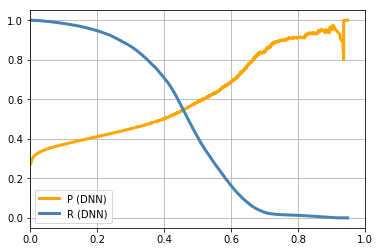

In [44]:
precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
#precision,recall,thresholds = precision_recall_curve(y,y_pred)

plt.plot(thresholds,precision[:-1],'r-',label='P (DNN)',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (DNN)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.grid()
plt.legend()

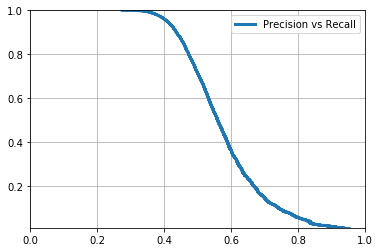

In [45]:
plt.figure(figsize=(15,15))

precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
#precision,recall,thresholds = precision_recall_curve(y,y_pred)

fig,ax = plt.subplots()
plt.plot(precision,recall,label='Precision vs Recall',lw=3)

ax.set_xbound(lower=0.0,upper=1.0)
ax.set_ybound(lower=0.01,upper=1.0)
plt.grid()
plt.legend()

(array([  1.85920000e+04,   4.23300000e+03,   2.69400000e+03,
          2.25200000e+03,   1.86900000e+03,   1.82200000e+03,
          1.64600000e+03,   1.64900000e+03,   1.67300000e+03,
          1.64900000e+03,   1.67900000e+03,   1.74200000e+03,
          1.69100000e+03,   1.91900000e+03,   1.97200000e+03,
          2.02200000e+03,   2.25600000e+03,   2.32500000e+03,
          2.62500000e+03,   2.57500000e+03,   2.83500000e+03,
          3.11200000e+03,   3.56900000e+03,   3.83000000e+03,
          3.71100000e+03,   3.41400000e+03,   2.98400000e+03,
          2.49800000e+03,   2.31000000e+03,   2.12100000e+03,
          1.95900000e+03,   1.75700000e+03,   1.48800000e+03,
          1.20200000e+03,   9.41000000e+02,   6.56000000e+02,
          4.07000000e+02,   2.28000000e+02,   1.12000000e+02,
          6.30000000e+01,   3.40000000e+01,   3.50000000e+01,
          4.40000000e+01,   5.40000000e+01,   6.20000000e+01,
          7.30000000e+01,   7.30000000e+01,   4.60000000e+01,
        

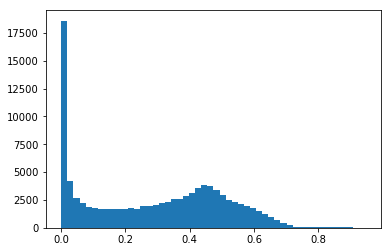

In [46]:
plt.figure()
plt.hist(y_pred,50)